# Additional assignment. Kaggle dataset. House cost prediction

This dataset is taken to practice Week1 material on linear regression.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection as mod_sel

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
initial_train_data = pd.read_csv('data/10. train.csv')
initial_test_data = pd.read_csv('data/10. test.csv')

In [3]:
initial_train_data.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
215,216,20,RL,72.0,10011,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2006,WD,Normal,134450
1435,1436,20,RL,80.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,7,2008,COD,Abnorml,174000
454,455,90,RL,63.0,9297,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Family,188000
1384,1385,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal,105000
1113,1114,20,RL,66.0,8923,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,134500


In [4]:
train_data = initial_train_data.loc[:, ['LotArea']]
train_labels = initial_train_data.loc[:, ['SalePrice']]

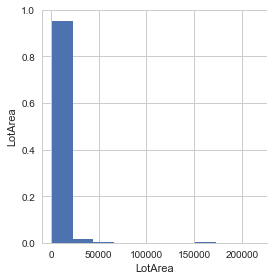

In [5]:
sns.pairplot(train_data, size=4.)

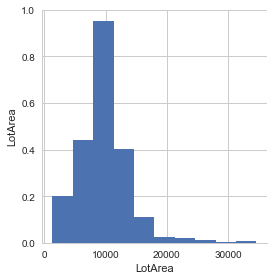

In [6]:
main_data = train_data.loc[train_data['LotArea'] < 35000]
outliers = train_data.loc[train_data['LotArea'] >= 35000]

#train_data.loc[train_data['LotArea'] < 35000].plot(y='LotArea', kind='hist')
sns.pairplot(main_data, size=4.)

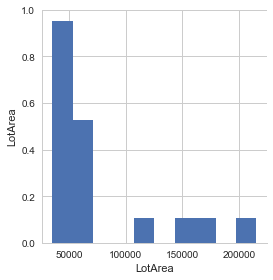

In [7]:
sns.pairplot(outliers, size=4.)

In [8]:
def getFeatureMatrix(df):
    onesCol = np.ones((df.shape[0], 1))
    return np.concatenate([onesCol, df.values], axis=1)

array([[12.24769432],
       [12.10901093],
       [12.31716669],
       ...,
       [12.49312952],
       [11.86446223],
       [11.90158345]])

In [63]:
from sklearn.metrics import mean_squared_error

trFeatures = getFeatureMatrix(train_data)
trLabels = train_labels.values

def predict(weights, features=trFeatures):
    return np.dot(features, weights.T)

def get_error(weights):
    predictions = predict(weights, trFeatures)
    if len(weights.shape) == 1 or weights.shape[1] == 1:
        return mean_squared_error(trLabels, predictions)
    else:
        labels = np.broadcast_to(trLabels, predictions.shape)
        return mean_squared_error(labels, predictions, multioutput='raw_values')

ws = np.array([[1, 1], [2, 2], [3, 3]])
get_error(ws)

array([3.50255182e+10, 3.14321330e+10, 2.82591119e+10])

In [77]:
trLogLabels = np.log(trLabels)

def get_log_error(weights):
    predictions = np.log(predict(weights, trFeatures))
    
    if len(weights.shape) == 1 or weights.shape[1] == 1:
        return np.sqrt(mean_squared_error(trLogLabels, predictions))
    else:
        labels = np.broadcast_to(trLogLabels, predictions.shape)
        return np.sqrt(mean_squared_error(labels, predictions, multioutput='raw_values'))

ws = np.array([[1, 1], [2, 2], [3, 3]])
get_log_error(ws)

array([2.95767061, 2.27812987, 1.88522236])

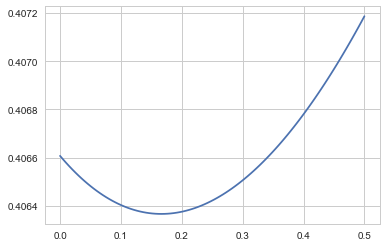

In [78]:
xs = np.linspace(0, .5, 100)[:, None]
bias = np.ones(xs.shape) * 180000

ws = np.concatenate([bias, xs], axis=1)
ys = get_log_error(ws)

plt.plot(xs, ys)

In [80]:
from scipy.optimize import minimize

ws0 = np.array([[180000, 1.0]])
get_log_error(ws0)

res = minimize(get_log_error, x0=ws0) #, method='L-BFGS-B', bounds=[(-100, 100), (-5, 5)])
min_ws = res.x
res

      fun: 0.4063664450168475
 hess_inv: array([[1.00000151e+00, 9.26073915e-03],
       [9.26073915e-03, 6.00298279e+01]])
      jac: array([1.17719173e-06, 1.07660890e-06])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([1.80000000e+05, 1.66502336e-01])

In [81]:
n = 10
pr = predict(min_ws)[:n, None]
gt = trLabels[:n]

(pr - gt)/gt
# np.concatenate([gt, pr - gt, (pr - gt)/gt ], axis=1)

array([[-0.12994271],
       [ 0.00054227],
       [-0.18624988],
       [ 0.29707212],
       [-0.27050271],
       [ 0.27517609],
       [-0.4082117 ],
       [-0.09135686],
       [ 0.39352574],
       [ 0.53589362]])

In [82]:
test_data = initial_test_data.loc[:, ['LotArea']]

testFeatures = getFeatureMatrix(test_data)
testPredictions = predict(min_ws, features=testFeatures)

submission = pd.DataFrame({'Id': initial_test_data.Id, 'SalePrice': testPredictions})
# you could use any filename. We choose submission here
submission.to_csv('out/submission.csv', index=False)